In [32]:
# business context: objective, data sourcing, goal...

#1.set up the environment
rm(list = ls())
gc()

#1a. loading pkgs
pkg.list <- c("dplyr", 
              "tidyr", 
              "caret",
              "stringr",
              "lubridate",
              "dummies",
              "ggplot2",
              "randomForest",
              "caret",
              "data.table",
              "devtools",
              "sweep")

new.pkgs <- pkg.list[!pkg.list %in% installed.packages()[, "Package"]]

if (length(new.pkgs) > 0) {install.packages(new.pkgs, dependencies = TRUE)}
lapply(pkg.list, require, character.only = TRUE)

#1b. set up the work dir
setwd("/Users/trpff26/Desktop/misc/housing_project")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2385411,127.4,3886542,207.6,3886542,207.6
Vcells,3836292,29.3,47136102,359.7,76609816,584.5


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

In [2]:
#2. data load in
dat <- fread("housing_data.csv", header = TRUE, na.strings = c("", " ", "NA"))
head(dat)

Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,⋯,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
Abbotsford,68 Studley St,2,h,NA,SS,Jellis,3/9/16,2.5,3067,⋯,1,1,126,NA,NA,Yarra,-37.8014,144.9958,Northern Metropolitan,4019
Abbotsford,85 Turner St,2,h,"$1,480,000",S,Biggin,3/12/16,2.5,3067,⋯,1,1,202,NA,NA,Yarra,-37.7996,144.9984,Northern Metropolitan,4019
Abbotsford,25 Bloomburg St,2,h,"$1,035,000",S,Biggin,4/2/16,2.5,3067,⋯,1,0,156,79,1900,Yarra,-37.8079,144.9934,Northern Metropolitan,4019
Abbotsford,18/659 Victoria St,3,u,NA,VB,Rounds,4/2/16,2.5,3067,⋯,2,1,0,NA,NA,Yarra,-37.8114,145.0116,Northern Metropolitan,4019
Abbotsford,5 Charles St,3,h,"$1,465,000",SP,Biggin,4/3/17,2.5,3067,⋯,2,0,134,150,1900,Yarra,-37.8093,144.9944,Northern Metropolitan,4019
Abbotsford,40 Federation La,3,h,"$850,000",PI,Biggin,4/3/17,2.5,3067,⋯,2,1,94,NA,NA,Yarra,-37.7969,144.9969,Northern Metropolitan,4019


In [3]:
#3. data understanding and cleaning

#3a. Price
dat[, Price := as.numeric(gsub('\\$|,','', trimws(Price)))]
dat <- dat[!is.na(Price)]

#3b. Date, Year
dat[, Date := dmy(Date)]
dat[, Month := month(Date)]
dat[, Year := as.character(year(Date))]


#3c. Postcode
dat[, Postcode := as.character(Postcode)]

#3d. factors 
factorCols <- names(dat)[sapply(dat, class) %in% "character"]
dat[, (factorCols) := lapply(.SD, as.factor), .SDcols = factorCols]
factorCols <- names(dat)[sapply(dat, class) %in% "factor"]

In [33]:
#4. Missing Values ----------------------------------------------------------
MISSING_THRES <- 0.5
dat.mr <- dat[, names(dat)[sapply(dat, function(x) sum(is.na(x))/nrow(dat)) < MISSING_THRES], with = FALSE]
dat[, sapply(.SD, function(x) sum(is.na(x)))/nrow(dat) > MISSING_THRES, .SDcols = names(dat)]
#show variables removed
                                  
                                  
sort(sapply(dat.mr, function(x) sum(is.na(x))/nrow(dat.mr)), decreasing = TRUE)

#dat[is.na(Bedroom2), "Bathroom", with = F] #bathrooms missing == bedrooms missing
#summary(dat[is.na(Bedroom2)]) #missing at random
#dat <- dat[complete.cases(dat)]

ERROR: Error in eval(expr, envir, enclos): object 'dat' not found


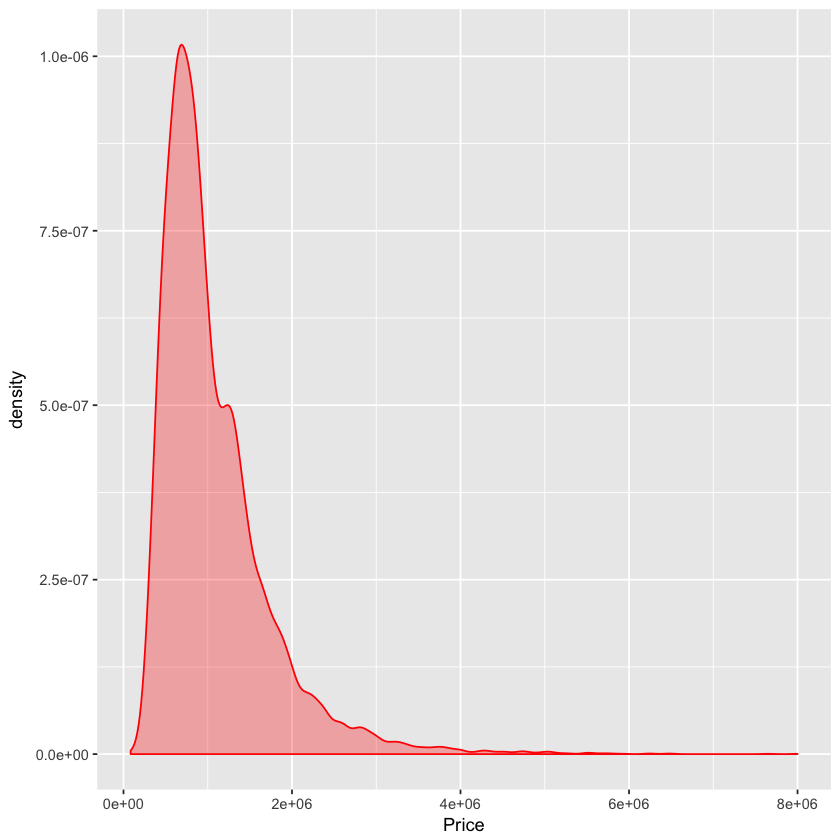

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   2.888   3.000  12.000 

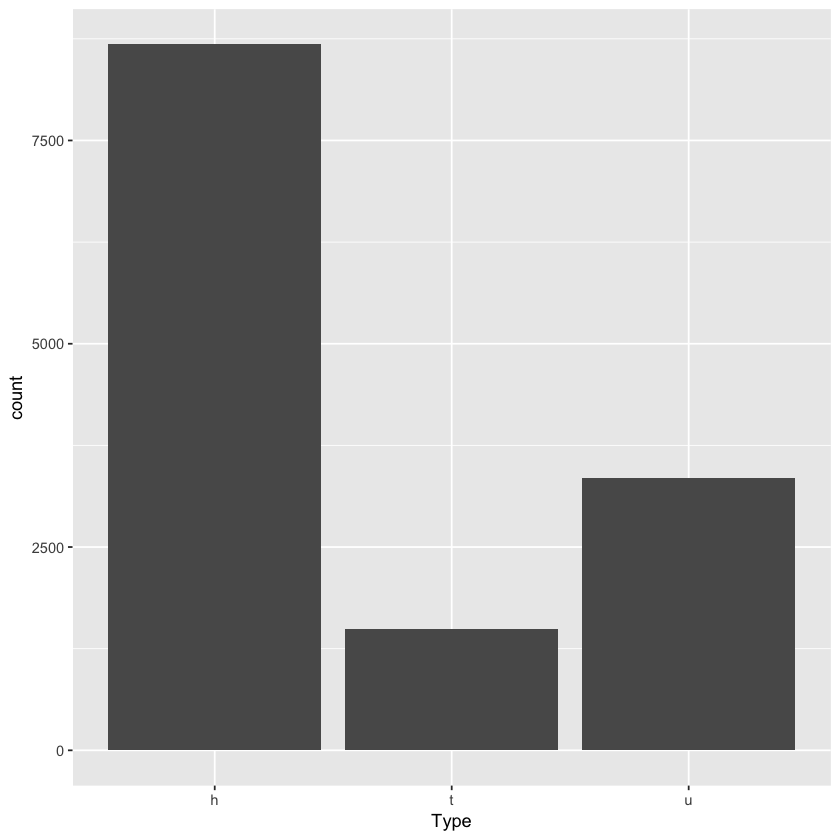

In [12]:
#4. Data Visulization

#4a. Univariate Analysis
# An example for continues
ggplot(dat.mr, aes(x = Price)) + geom_density(color = "red", fill = "red", alpha = 0.3)
# An exmaple for categorical variables
ggplot(dat.mr, aes(x = Type)) + geom_bar()
# An exmaple for numerical summaries
summary(dat$Rooms)

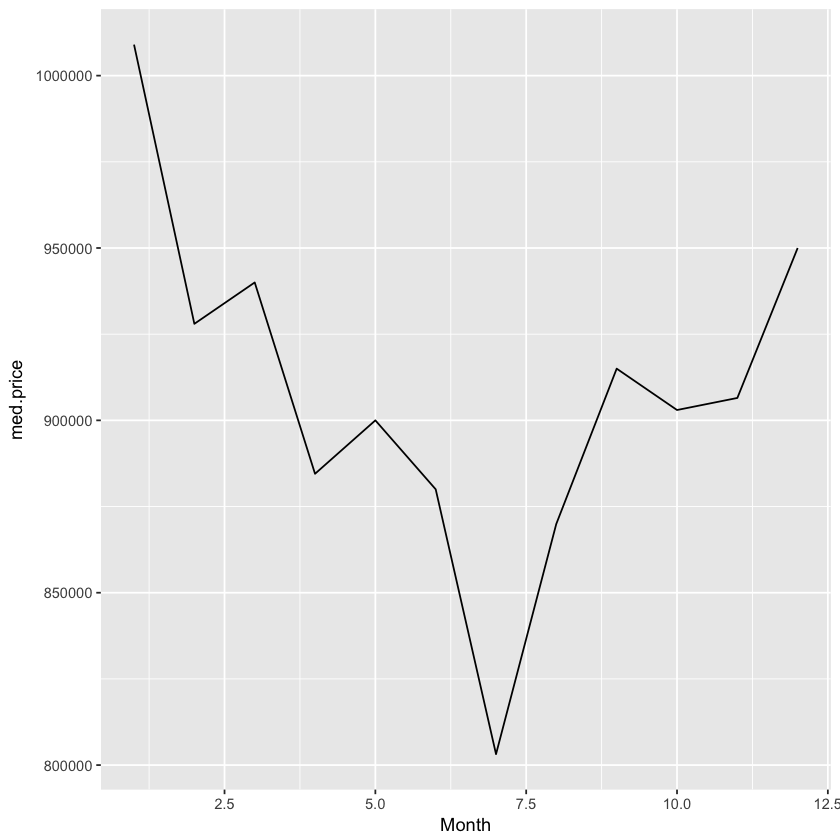

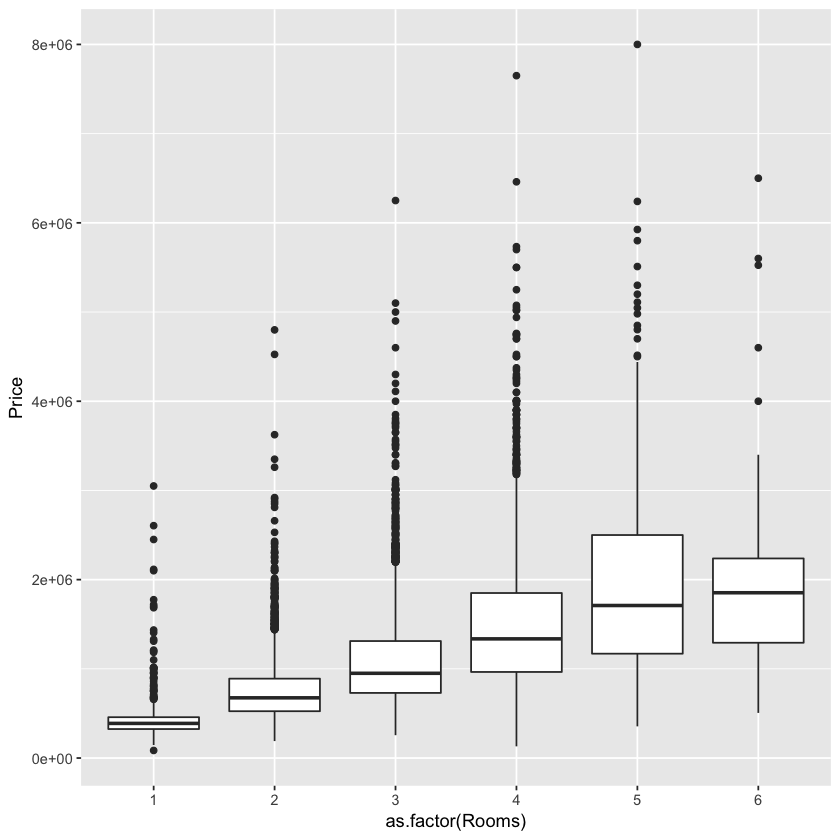

[1] -0.125904

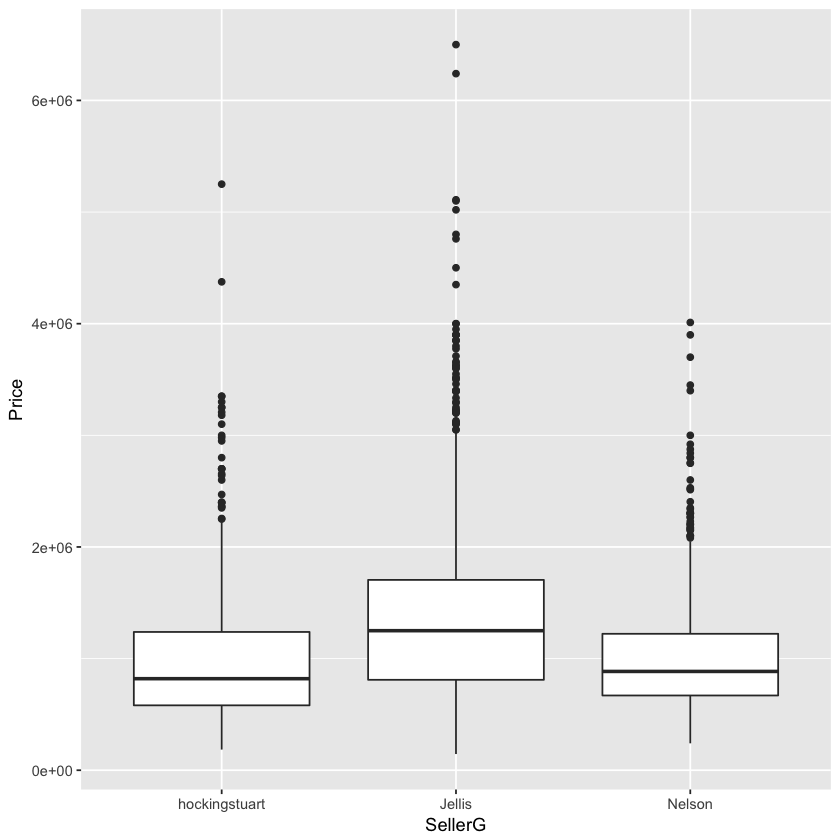

In [11]:
#4b. Multivariat Aanalysis
# potential features vs. target

# itemize the potential features 
monthprice <- dat.mr[, .(med.price = median(Price, na.rm = TRUE)), by = c("Month")]
ggplot(monthprice, aes(x = Month, y = med.price)) + geom_line()
ggplot(dat.mr[Rooms < 7], aes(x = as.factor(Rooms), y = Price)) + geom_boxplot()
ggplot(dat.mr[SellerG %in% c("Jellis", "Nelson", "hockingstuart")], aes(x = SellerG, y = Price)) + geom_boxplot()

# correlation analysis
cor(dat.mr$Distance, dat.mr$Price)

In [24]:
#5. Feature Engineering
# document the decision and explain
# comment on the results
dat.mr[, Postcode := substring(as.character(Postcode), 1, 2)]
dat.mr[, Postcode := as.factor(Postcode)]

In [25]:
# Removing feature round 1 ------------------------------------------------
# intuitively 
# base line model
# scientific method
dat.fr <- dat.mr[, !names(dat.mr) %in% c("CouncilArea", "Regionname", "Date", "Lattitude", "Longtitude", "Address", "Suburb"), with = FALSE]
sapply(dat.fr[, names(dat.fr) %in% factorCols, with = F], function(x) length(unique(x)))

Type   Method  SellerG Postcode     Year 
       3        5      262        8        2

In [26]:
# comment on why choosing this feature
topSellers <- sort(table(dat$SellerG), decreasing = TRUE)
topSellersName <- names(topSellers[1:20])
topSellersName

[1] "Nelson"        "Jellis"        "hockingstuart" "Barry"        
 [5] "Buxton"        "Marshall"      "Ray"           "Biggin"       
 [9] "Brad"          "Woodards"      "Fletchers"     "Greg"         
[13] "RT"            "Jas"           "Sweeney"       "Miles"        
[17] "McGrath"       "Gary"          "Noel"          "Hodges"

In [27]:
dat.fr[!SellerG %in% topSellersName, SellerG := "Others"]
length(unique(dat.fr$SellerG))
sapply(dat.fr[, names(dat.fr) %in% factorCols, with = F], function(x) length(unique(x)))

[1] 21

Type   Method  SellerG Postcode     Year 
       3        5       21        8        2

In [28]:
# Dummy
dum.dat <- dummy.data.frame(dat.fr, sep = ".")
dum.dat <- dum.dat[complete.cases(dum.dat), ]
#display features after the transformation

In [29]:
# Modeling - train/test split ---------------------------------------------
set.seed(1015)
trainIndex <- createDataPartition(dum.dat$Price, p = .8, list = FALSE, times = 1)
houseTrain <- dum.dat[trainIndex, ]
houseTest <- dum.dat[-trainIndex, ]

In [30]:
dim(houseTrain)
dim(houseTest)

[1] 8468   48

[1] 2114   48

mtry = 15  OOB error = 93164717406 
Searching left ...
mtry = 10 	OOB error = 97846335135 
-0.05025097 0.05 
Searching right ...
mtry = 22 	OOB error = 91855562933 
0.01405204 0.05 


,mtry,OOBError
10,10,97846335135
15,15,93164717406
22,22,91855562933


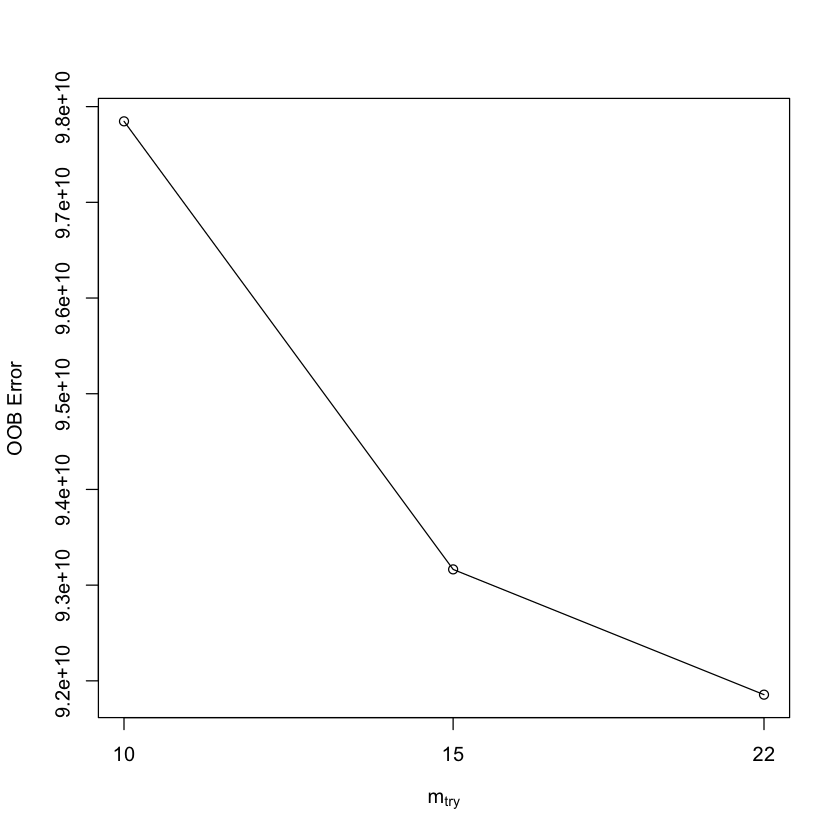

In [81]:
# Modeling - Train/Tune ---------------------------------------------
# what parameters you are tuning: # of trees(smaller size), number of features, 
bestmtry <- tuneRF(houseTrain[, !colnames(houseTrain) %in% "Price"], houseTrain$Price, stepFactor = 1.5, ntree = 100)
bestmtry

In [31]:
control <- rfeControl(functions = rfFuncs,
                   method = "repeatedcv",
                   repeats = 3,
                   verbose = FALSE)

label <- 'Price'
predictors <- names(houseTrain)[!names(houseTrain) %in% label]
pricePredProfile <- rfe(houseTrain[,predictors], houseTrain[, label],
                      rfeControl = control)
pricePredProfile


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables   RMSE Rsquared    MAE RMSESD RsquaredSD MAESD Selected
         4 484247   0.4931 309721  34218    0.02844 11572         
         8 334581   0.7504 210048  24230    0.01873  6757         
        16 309882   0.7776 188699  21899    0.01819  6850         
        47 307072   0.7817 186228  21990    0.01844  6685        *

The top 5 variables (out of 47):
   Distance, Landsize, Propertycount, Postcode.30, Bathroom


In [ ]:
# Modeling - Testing ---------------------------------------------
 

In [ ]:
# Business Interpretation 
# This is the way to interpret the model and better utilize the result